# Sewer network example

This example demonstrates the use of pysewer to generate a sewer network using the the following data inputs:
- A digital elevation model (DEM)
- Road network data
- Building footprint data

In this example the road and building data are generated using the [OSMnx] package.

The network is generated using the following steps:
1. Preprocessing of the input data. This involves setting input parameters and converting the input data to the correct format. This is then followed by instantiation of the network using pysewer.ModelDomain
2. Application of the routing algorithm to generate the sewer network. This is done using repeated shortest path heuristic (RSPH) algorithm. This is done using pysewer.rsph_tree ()
3. Hydraulic calculations and pump optimization 
4. Post processing of the results
5. Export of the generated sewer network to a geopackage file using the pysewer.export module. Shapefiles and geoparquet files are also supported.

## Preprocessing


In [1]:
import pysewer
import matplotlib.pyplot as plt
import networkx as nx
from pysewer.config.settings import load_config, config_to_dataframe  # load the the settings file 
from pysewer.export import export_sewer_network

### Load custom settings 
The customs settings are stored in yaml file within the notebook. The settings are loaded using the pysewer.config.settings.load_config function. This created a Config class from which settings are then passed to the pysewer.ModelDomain class to initialise the model domain.

Note the defaults settings are stored within the pysewer package. These can be viewed using the pysewer.config.settings.view_default_settings function.

The settings file is dived into 4 sections:
1. the preprocessing parameters settings
2. the optimization parameter settings. Use for carrying out the hydraulic calculations and pump optimization
3. the plot settings
4. the export settings

To change the settings, the user can either edit the yaml file or change the settings directly using the Config class. For example, to change the minimum trench depth of the sewer pipes to 1 m in the example_settings.yaml file, the user can change the following line:

```yaml
optimization:
  min_trench_depth: 0.5
```

Finally, one can display the final settings that would be used to initalise the mode.

In [2]:
# load custom settings from the example settings file
custom_config = load_config("./example_settings.yaml")
df_config = config_to_dataframe(custom_config)
display(df_config)

,Setting,Value
0,preprocessing_dem_file_path,example_data/1_DEM/dem_10m1.tif
1,preprocessing_roads_input_data,example_data/3_Roads/roads_projected.shp
2,preprocessing_buildings_input_data,example_data/2_Buildings/buildings_projected.shp
3,preprocessing_dx,10
4,preprocessing_pump_penalty,1000
5,preprocessing_max_connection_length,30
6,preprocessing_clustering,centers
7,preprocessing_connect_buildings,True
8,preprocessing_add_private_sewer,True
9,preprocessing_field_get_sinks,node_type


In [3]:
# Instantiate the model domain
test_model_domain = pysewer.ModelDomain(
    dem=custom_config.preprocessing.dem_file_path,
    buildings=custom_config.preprocessing.buildings_input_data,
    roads=custom_config.preprocessing.roads_input_data,
    clustering=custom_config.preprocessing.clustering,
)

/Users/despot/miniconda3/envs/pysewer/lib/python3.10/site-packages/shapely/linear.py:208: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/Users/despot/miniconda3/envs/pysewer/lib/python3.10/site-packages/shapely/linear.py:208: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/Users/despot/miniconda3/envs/pysewer/lib/python3.10/site-packages/shapely/linear.py:208: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/Users/despot/miniconda3/envs/pysewer/lib/python3.10/site-packages/shapely/linear.py:208: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/Users/despot/miniconda3/envs/pysewer/lib/python3.10/site-packages/shapely/linear.py:208: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/Users/despot/miniconda3/envs/pysewer/li

In [4]:
# setting and adding the sinks. Sinks are the lowest points in the model domain where WWTP are considered to be located. 
test_model_domain.set_sink_lowest()
test_model_domain.add_sink((690500, 2557000))

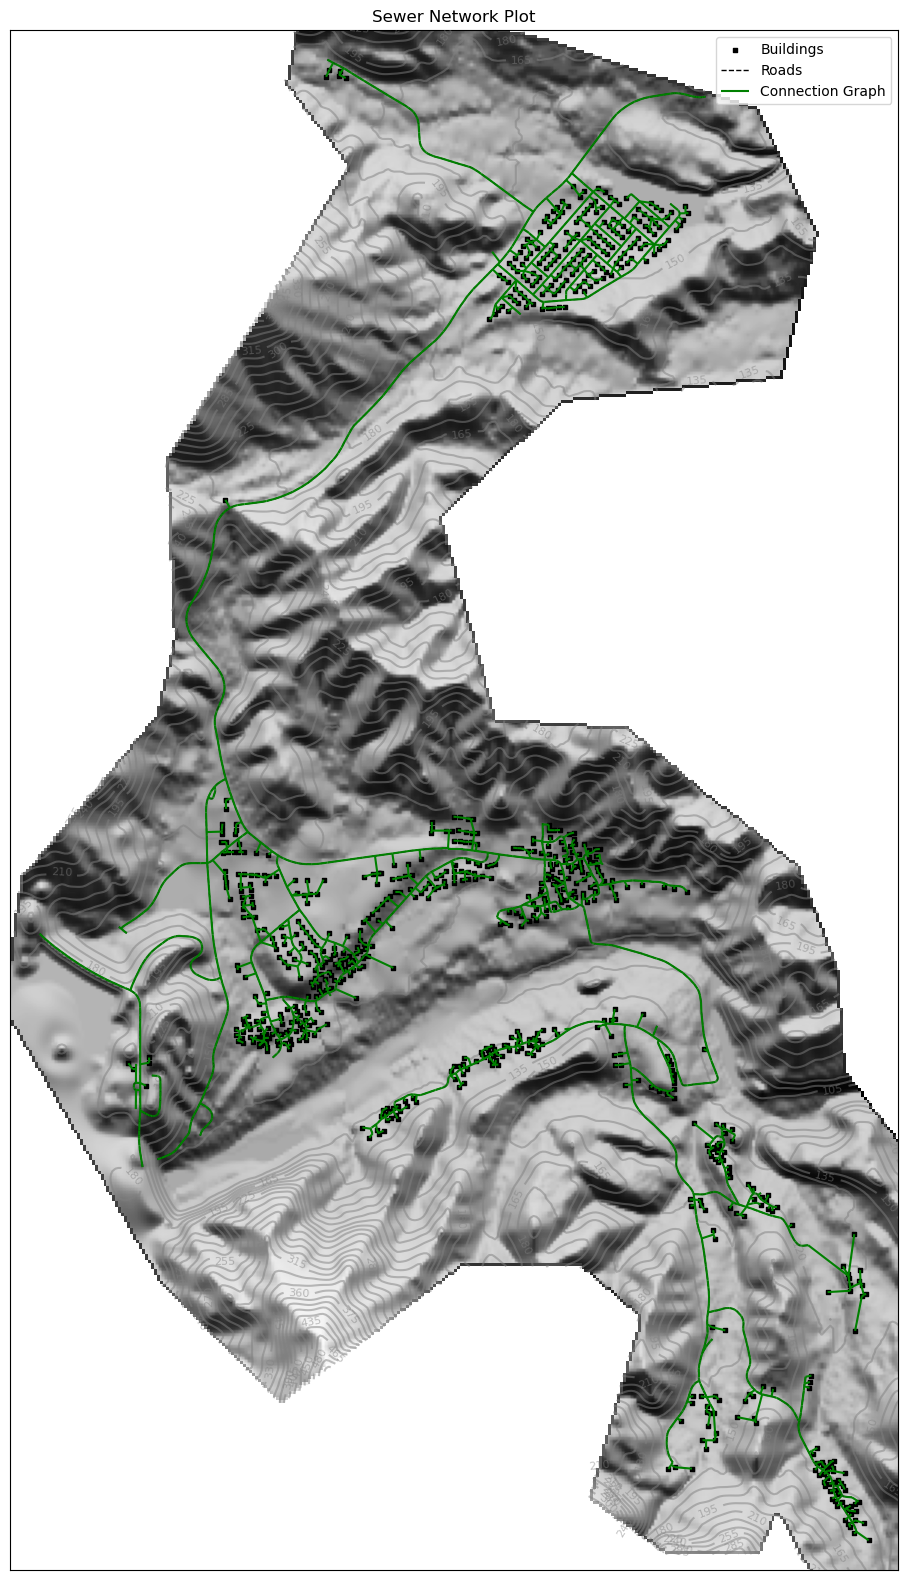

In [5]:
fig, ax = pysewer.plot_model_domain(
    test_model_domain,
    plot_connection_graph=custom_config.plotting.plot_connection_graph,
    hillshade=custom_config.plotting.hillshade,
)

In [6]:
# preview the the buildings geoDataFrame
test_model_domain.buildings.get_gdf().head()


,OBJECTID,SUBTYPELBL,ROADNAMEA,ROADNAMEE,ROADNO,SHAPE_Leng,Shape_Le_1,geometry
0,8696,WAY,شارع الظاهر,al Dhahir Street,0.0,292.317700,292.272612,"LINESTRING (691331.435 2553788.287, 691357.594..."
1,9469,WAY,None,None,0.0,64.172012,64.172002,"LINESTRING (691395.982 2553820.064, 691396.500..."
2,9470,WAY,None,None,0.0,90.341907,90.341979,"LINESTRING (690606.625 2554799.500, 690612.375..."
3,9471,WAY,None,None,0.0,220.794595,220.790365,"LINESTRING (689539.873 2554939.387, 689538.108..."
4,9477,WAY,شارع السيح,al Saih Street,0.0,315.380259,315.380207,"LINESTRING (689794.875 2554488.750, 689798.250..."


In [7]:
# create the the graph conections
# this to be used for the routing algorithm
connection_graph = test_model_domain.generate_connection_graph()

3431
1452
Simplified graph: 3431 to 1427 nodes, 3958 to 1953 edges


In [8]:
# get the sinks within the area of interest. 
# verify that the sinks were addeded
test_model_domain.get_sinks()

[(691258.1220546402, 2554226.804832181), (690500.0, 2557000.0)]

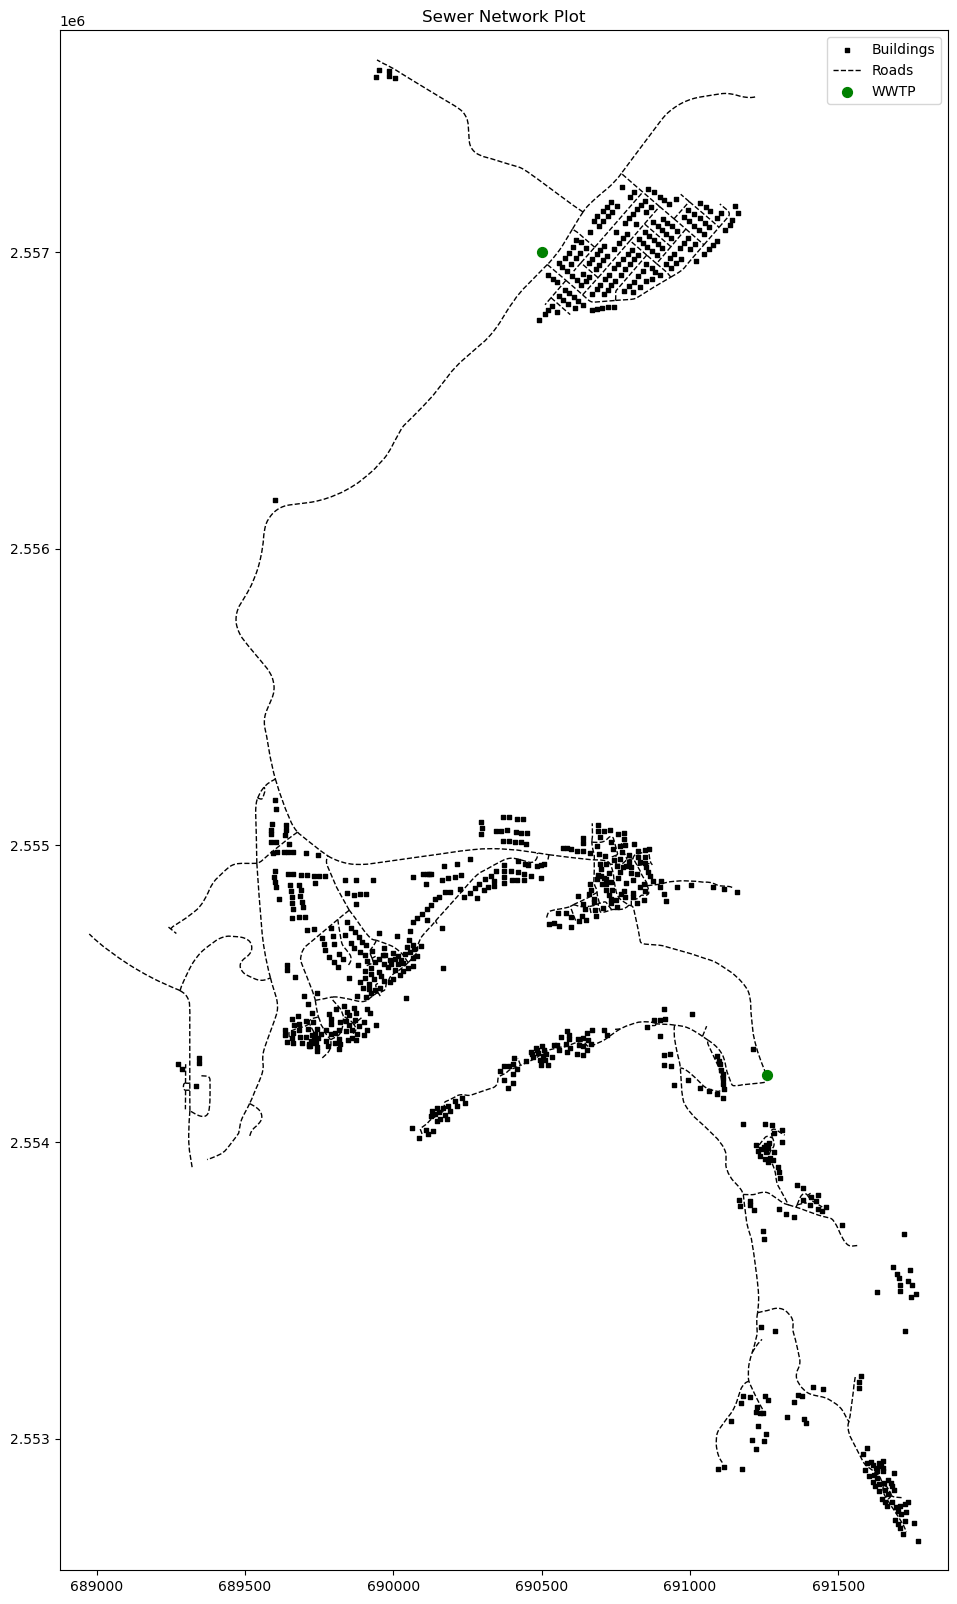

In [9]:
fig, ax = pysewer.plot_model_domain(
    test_model_domain, plot_sink=custom_config.plotting.plot_sink
)

## Routing Solver

For the network routing, an rhsp tree growing algorithm was implemented.


In [11]:
layout = pysewer.rsph_tree(connection_graph, test_model_domain.get_sinks(), "building")

No pumping station in the sewer graph
Plotting sewer graph without pumping station


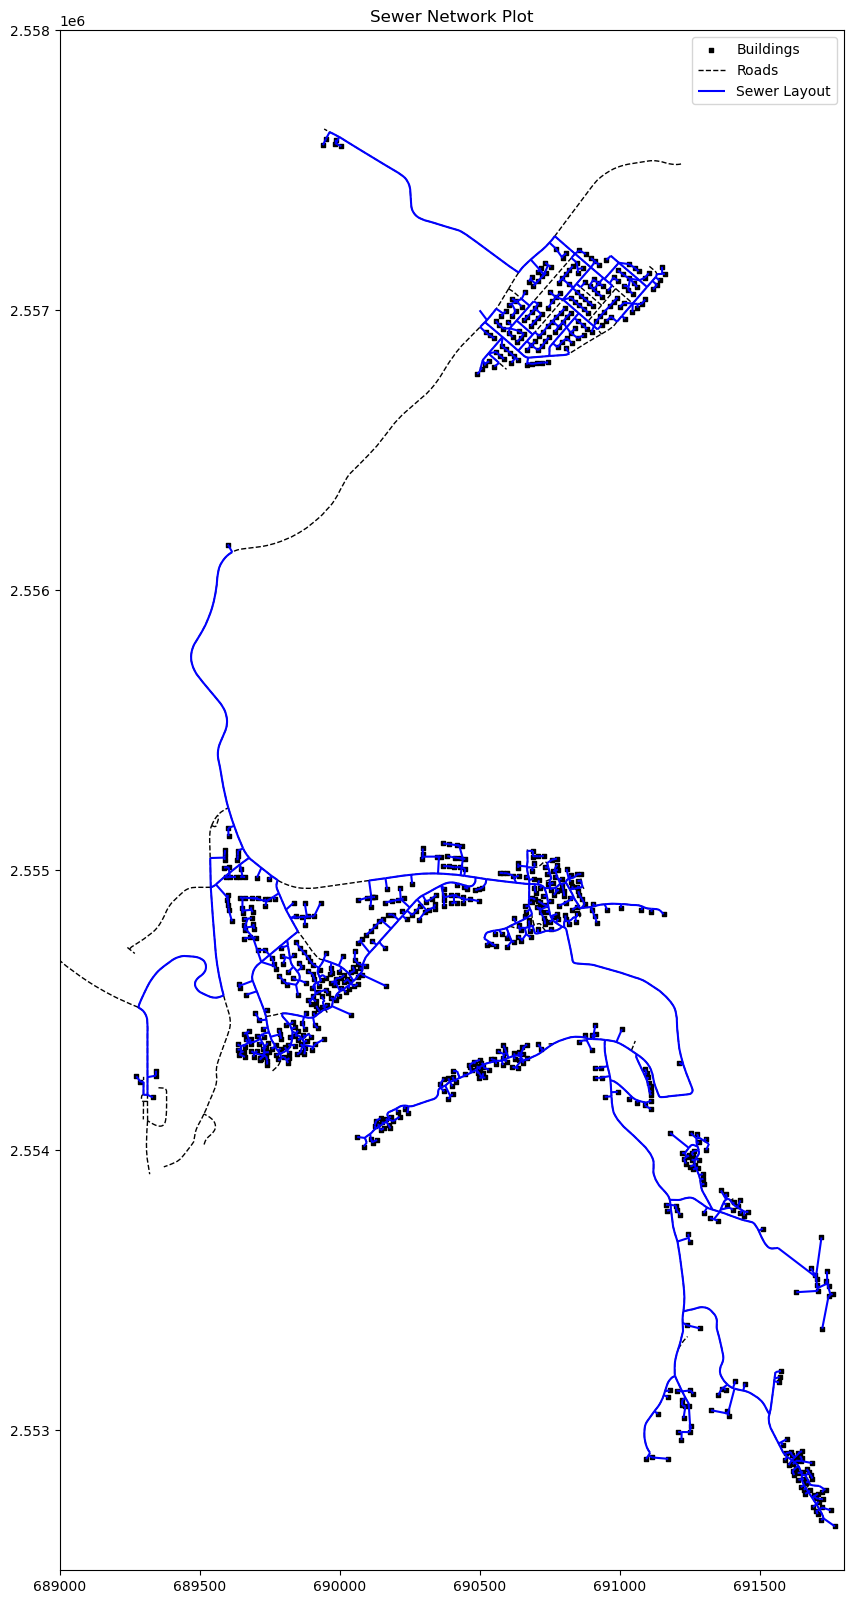

In [12]:
fig, ax = pysewer.plot_model_domain(
    test_model_domain, plot_sewer=True, sewer_graph=layout
)
ax.set_xlim(689000, 691800)
ax.set_ylim(2552500, 2558000)
plt.show()

## Pump Optimization


0


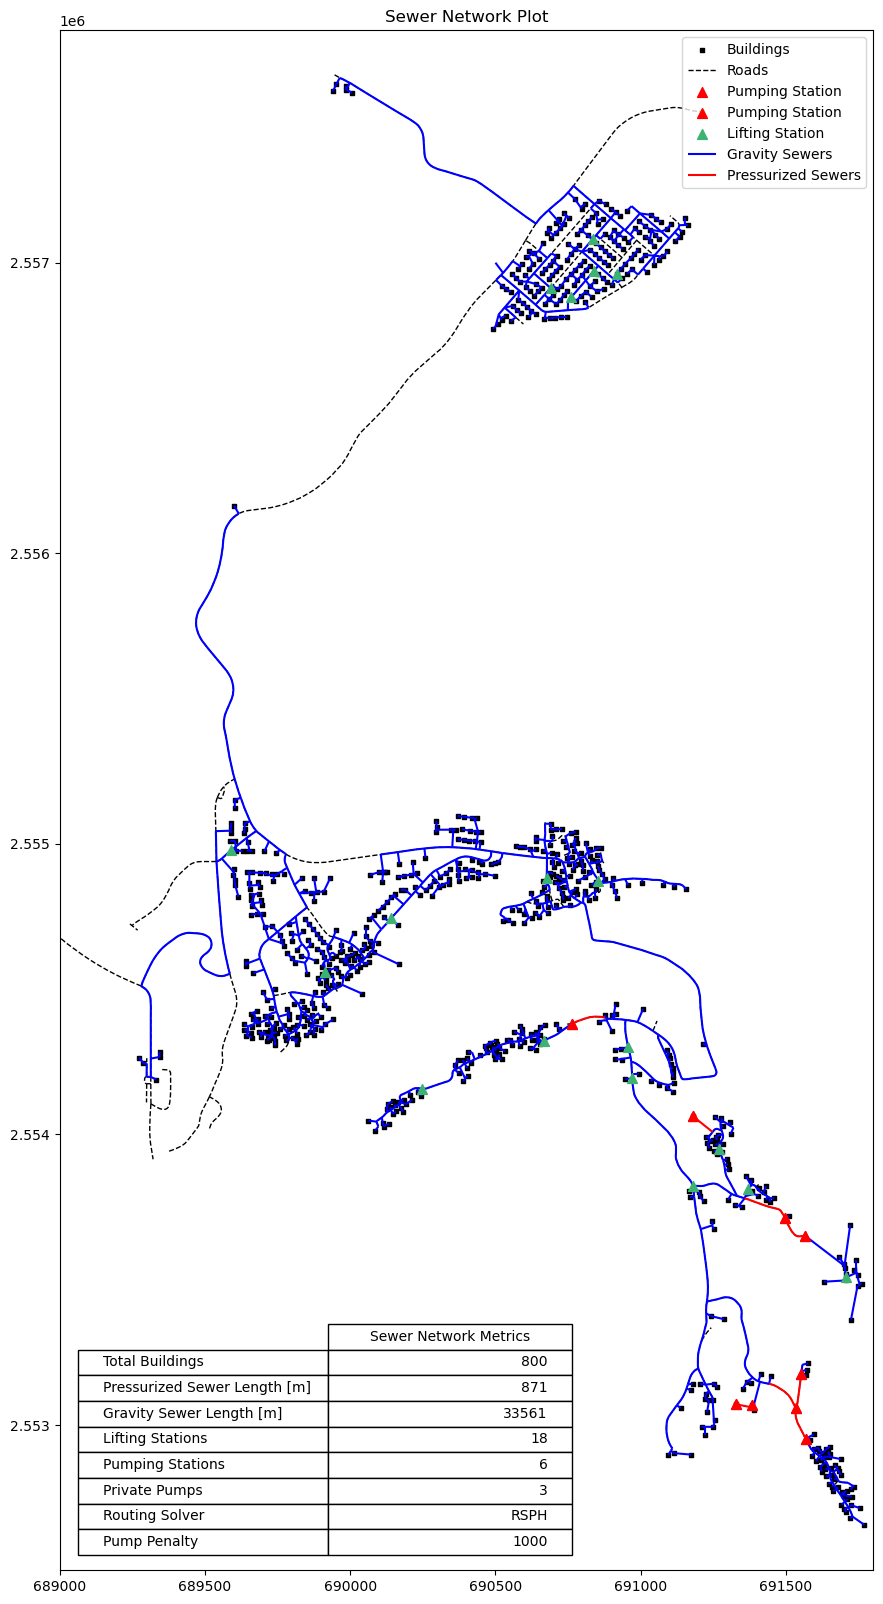

In [13]:
G = pysewer.estimate_peakflow(
    layout,
    inhabitants_dwelling=custom_config.optimization.inhabitants_dwelling,
    daily_wastewater_person=custom_config.optimization.daily_wastewater_person,
)
G = pysewer.calculate_hydraulic_parameters(
    layout,
    sinks=test_model_domain.get_sinks(),
    diameters=custom_config.optimization.diameters,
    pressurized_diameter=custom_config.optimization.pressurized_diameter,
    include_private_sewer=True,
    roughness=custom_config.optimization.roughness,
)
info = pysewer.get_sewer_info(G)
info["Routing Solver"] = "RSPH"
info["Pump Penalty"] = test_model_domain.pump_penalty
fig, ax = pysewer.plot_model_domain(
    test_model_domain, plot_sewer=True, sewer_graph=G, info_table=info
)
ax.set_xlim(689000, 691800)
ax.set_ylim(2552500, 2557800)

ax.set_title("Sewer Network Plot")
plt.legend(loc="upper right")
plt.show()

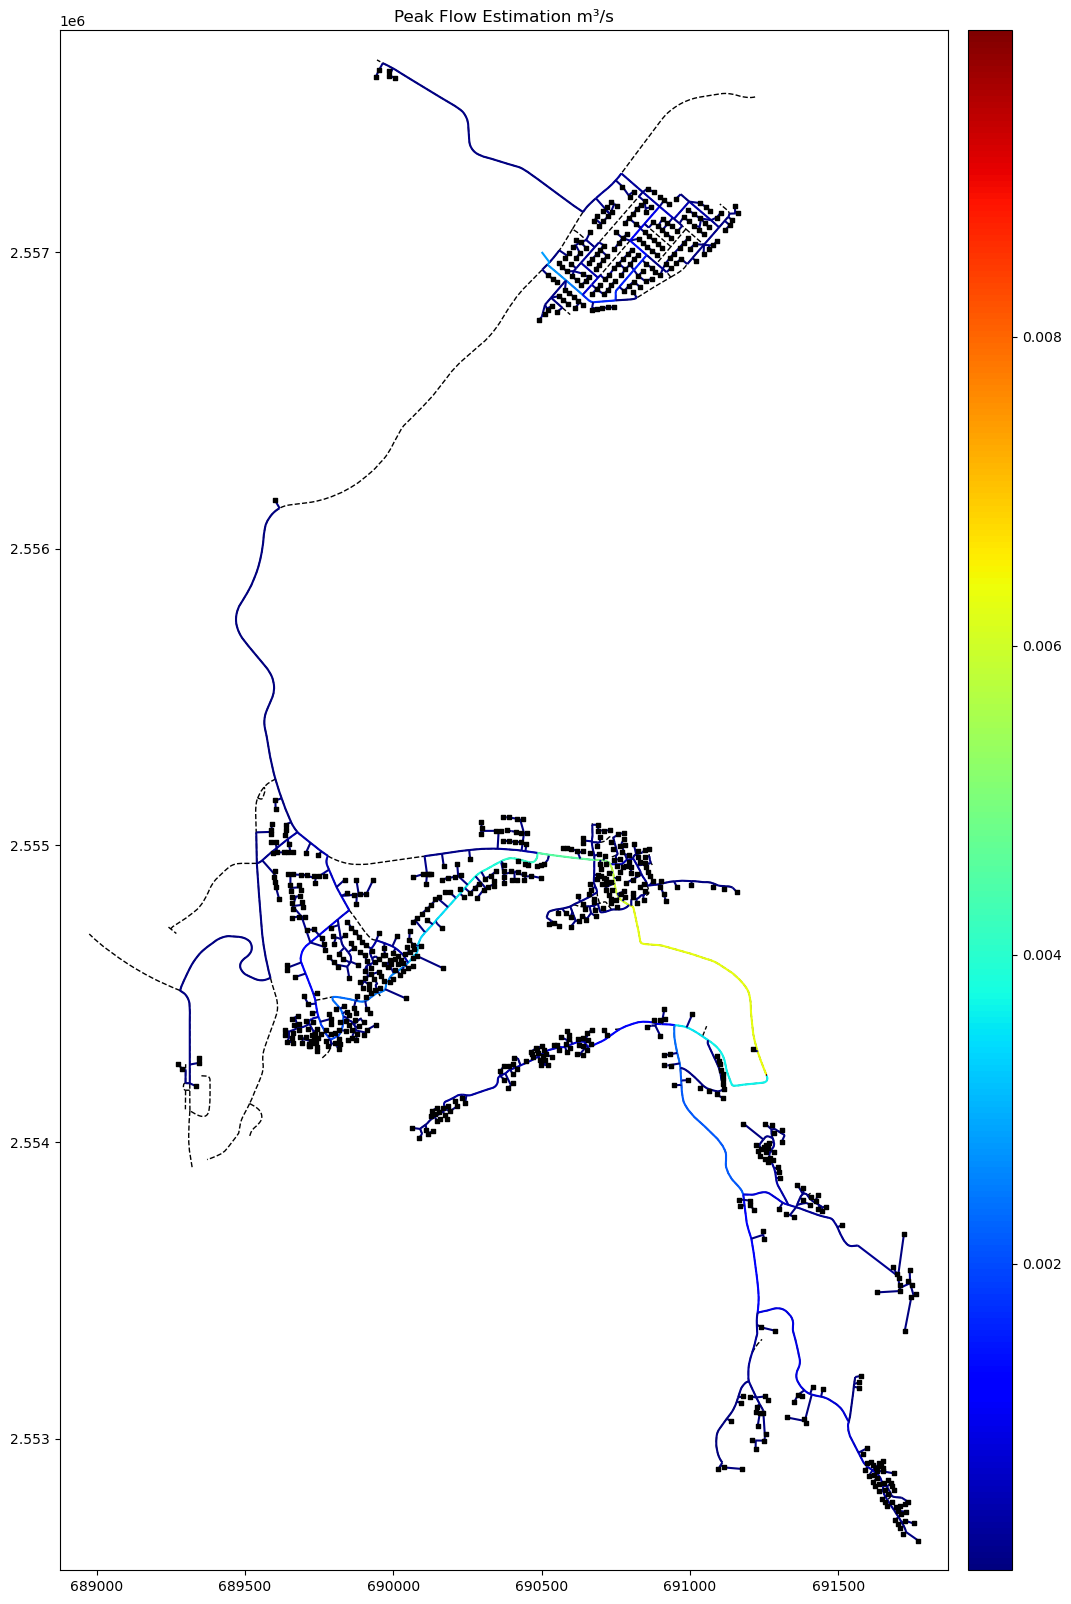

In [14]:
pysewer.plot_sewer_attributes(
    test_model_domain, G, attribute="peak_flow", title="Peak Flow Estimation m³/s"
)
plt.show()

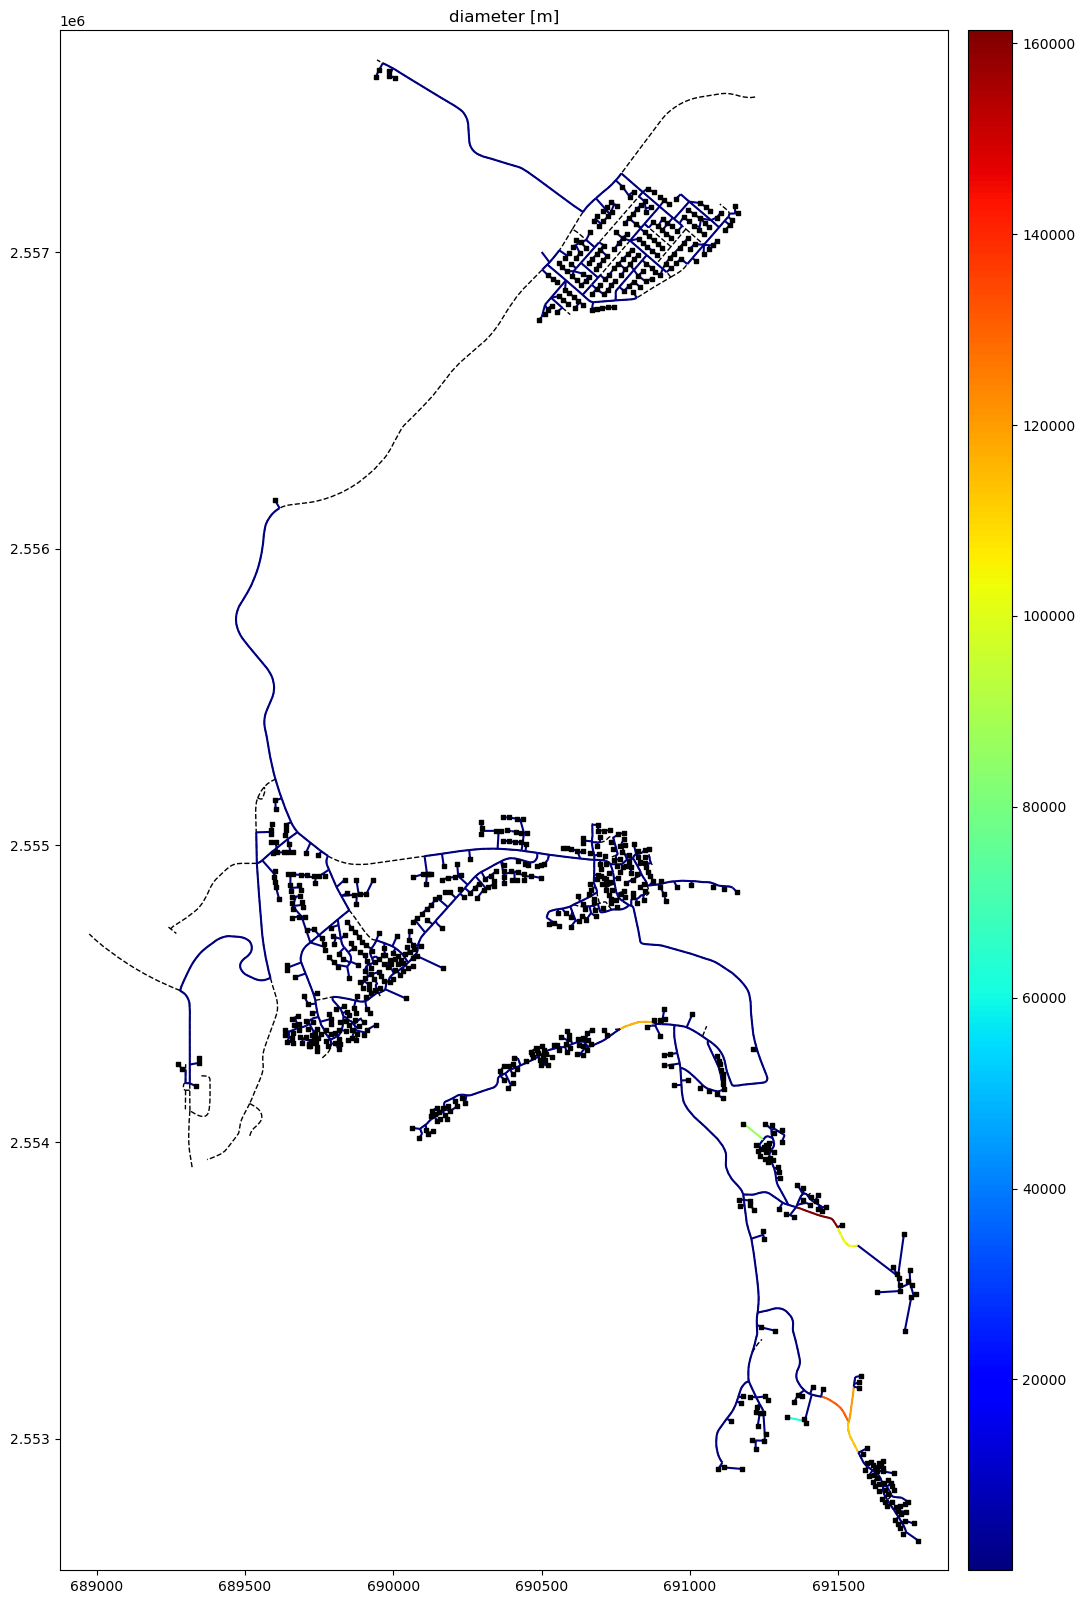

In [15]:
pysewer.plot_sewer_attributes(
    test_model_domain, G, attribute="weight", title="diameter [m]"
)
plt.show()

## Export Sewer Network


In [16]:
from pysewer.export import export_sewer_network

sewer_network_gdf = pysewer.get_edge_gdf(G, detailed=True)
export_sewer_network(sewer_network_gdf, "sewer_network.gpkg")

Successfully exported sewer network to sewer_network.gpkg.


In [20]:
# check the file that was created 
import geopandas as gpd
sn_gdf = gpd.read_file("sewer_network.gpkg")
sn_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1388 entries, 0 to 1387
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   distance              1388 non-null   float64 
 1   profile               1388 non-null   object  
 2   needs_pump            1388 non-null   object  
 3   weight                1388 non-null   float64 
 4   pressurized           1388 non-null   object  
 5   trench_depth_profile  1388 non-null   object  
 6   mean_td               1388 non-null   float64 
 7   diameter              1388 non-null   float64 
 8   peak_flow             1388 non-null   float64 
 9   edge_counter          1388 non-null   int64   
 10  OBJECTID              26 non-null     float64 
 11  SUBTYPELBL            1388 non-null   object  
 12  ROADNAMEA             1371 non-null   object  
 13  ROADNAMEE             1371 non-null   object  
 14  ROADNO                26 non-null     float64 
 

In [17]:
sewer_network_gdf = pysewer.get_edge_gdf(G, detailed=True)
sewer_network_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1388 entries, 0 to 1387
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   geometry              1388 non-null   geometry
 1   distance              1388 non-null   float64 
 2   profile               1388 non-null   object  
 3   needs_pump            1388 non-null   bool    
 4   weight                1388 non-null   float64 
 5   pressurized           1388 non-null   bool    
 6   trench_depth_profile  1388 non-null   object  
 7   mean_td               1388 non-null   float64 
 8   diameter              1388 non-null   float64 
 9   peak_flow             1388 non-null   float64 
 10  edge_counter          1388 non-null   int64   
 11  OBJECTID              26 non-null     float64 
 12  SUBTYPELBL            26 non-null     object  
 13  ROADNAMEA             9 non-null      object  
 14  ROADNAMEE             9 non-null      object  
 

In [ ]:
# try using geoparquet to save the geodataframe
sewer_network_gdf.to_parquet("sewer_parq.parquet", index=False)

In [ ]:
test_parq = gpd.read_parquet("sewer_parq.parquet")
test_parq.info()
test_parq